In [6]:
#%% Import packages and load data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [7]:
#%% load preprocessed data

df = pd.read_csv('/Users/apple/Downloads/processed_data_socmot.csv')
# This final data has been through following preprocessing steps: (details see SocMot_EDA.ipynb)
# 1. Extract data with interest:only keep wave2 (pandemic) data (since only wave2 has SWLS)
# 2. Deal with missing values: drop social motives that only apply to a small subset of the sample (KCC, MRT, MRB) then impute missing values
# 3. Coarse-grain: merge country into continent 
# 4. Imbalance categories: filter out categories with extremely few records (Oceania in Continent, Other in Gender, Divorced/Widowed in Relationship) then up-sample to make categories more balanced

In [10]:
#%% Claim variables

# detailed description of variables and preprocess can be found in SocMot_EDA.ipynb

#target variable
target='swls'
#Satisfaction with life composite

#numerical variables
abandoned_motives = ['KCC','MRT','MRB']
social_motives = [x for x in ['SPO','DIS', 'AFG','AFI','AFX','STA','MAT','KCF'] if x not in abandoned_motives]
#Self-protection (SPO), Disease Avoidance (DIS), Affiliation (Group) (AFG), Affiliation (Independence) (AFI), Affiliation (Exclusion Concern) (AFX), Status (STA), Mate Seeking (MAT), Breakup Concern (MRB), Mate Retention (MRT), Kin Care (Family) (KCF), Kin Care (Children) (KCC).
#MRB, MRT, KCC are abandoned, as they only apply to a small subset of the sample

learn_social_motives = [f'learn{sm}' for sm in social_motives]

not_motives_numerical_vars=['SubjSES', 'Age', 'Children', 'Food', 'Water', 'Sleep', 'Temperature', 'Safe']

numerical_vars = not_motives_numerical_vars + social_motives + learn_social_motives


# Ensure all numerical variables and target are numeric
df[numerical_vars] = df[numerical_vars].apply(pd.to_numeric, errors='coerce')
df[target] = df[target].apply(pd.to_numeric, errors='coerce')


#categorical variables
categorical_vars=["Gender", "Relationship","Continent"]
# Note Country and Continent are related, I only use Continent instead of Country for coarse-grained robustness

In [11]:
# %% 

# Preprocessing features
X_num = df[numerical_vars]
X_cat = df[categorical_vars]

# Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out())


X = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
y = df[target]

print("Features shape:", X.shape)
print("\nFirst few rows of features:")
print(X.head())
print("\nFirst few rows of target:")
print(y.head())

Features shape: (6914, 38)

First few rows of features:
    SubjSES       Age  Children    Food     Water     Sleep  Temperature  \
0 -0.623029 -0.860878 -0.436772  0.4821  0.401934  0.429817     0.525169   
1 -1.186633 -0.860878 -0.436772  0.4821  0.401934  0.429817     0.525169   
2 -1.750237 -0.051929 -0.436772  0.4821  0.401934  0.429817     0.525169   
3 -1.750237 -0.051929 -0.436772  0.4821  0.401934  0.429817     0.525169   
4  0.504179 -0.770995 -0.436772  0.4821  0.401934  0.429817    -1.118942   

       Safe       SPO       DIS  ...  Relationship_Divorced/Widowed  \
0  0.728488  0.307635 -0.357839  ...                            0.0   
1  0.728488  0.307635  1.116106  ...                            0.0   
2  0.728488  0.334968  0.472930  ...                            0.0   
3  0.728488  0.717626 -0.625829  ...                            0.0   
4  0.015368 -0.239019  0.044146  ...                            0.0   

   Relationship_Married  Relationship_Relationship  Relation

In [14]:
                        #%%

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=133)

In [16]:
#%%

def train_evaluate(model, X_train, X_test, y_train, y_test, params="default"):
    """
    Train model with given parameters and evaluate performance
    
    Args:
        model: sklearn model object
        X_train, X_test, y_train, y_test: train/test data splits
        params: dictionary of model parameters (optional)
        
    Returns:
        Dictionary containing model parameters and evaluation metrics
    """
    from sklearn.metrics import r2_score, mean_squared_error
    
    
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    metrics = {
        'performance': {
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred))
        }
    }
    
    # Get feature importance for linear models and tree models
    if hasattr(model, 'coef_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Coefficient': model.coef_
        }).sort_values('Coefficient', key=abs, ascending=False)
        metrics['feature_importance'] = feature_importance
    elif hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        metrics['feature_importance'] = feature_importance
    
    # Print results
    print(f"\n{type(model).__name__} Results:")
    print(f"Model parameters: {params}")
    print(f"Train R2: {metrics['performance']['train_r2']:.3f}")
    print(f"Test R2: {metrics['performance']['test_r2']:.3f}") 
    print(f"Train RMSE: {metrics['performance']['train_rmse']:.3f}")
    print(f"Test RMSE: {metrics['performance']['test_rmse']:.3f}")
    
    if 'feature_importance' in metrics:
        print("\nFeature Importance:")
        print(metrics['feature_importance'])
        
    return metrics

In [17]:
#%% Model Exploration 

# train different models and compare performance
performance_metrics = {}

# Note: for those numerical parameters, I tried some different ranges and found that the effect was relatively salient within used interval. Therefore, these values are included in the final model for comparison.

In [18]:
#%% Linear Model

# Linear Model

In [19]:
#%% Basic Linear Regression

# Basic Linear Regression
from sklearn.linear_model import LinearRegression

for fit_intercept in [True, False]:
    lr_model = LinearRegression(fit_intercept=fit_intercept)
    lr_results = train_evaluate(lr_model, X_train, X_test, y_train, y_test, params=f"fit_intercept={fit_intercept}")
    model_name = f'Linear Regression (intercept={fit_intercept})'
    performance_metrics[model_name] = lr_results['performance']


LinearRegression Results:
Model parameters: fit_intercept=True
Train R2: 0.281
Test R2: 0.261
Train RMSE: 1.159
Test RMSE: 1.162

Feature Importance:
                          Feature   Coefficient
29           Relationship_Married  6.061488e+11
30      Relationship_Relationship  6.061488e+11
27            Relationship_Dating  6.061488e+11
28  Relationship_Divorced/Widowed  6.061488e+11
31            Relationship_Single  6.061488e+11
26                   Gender_Other -2.936226e+11
25                    Gender_Male -2.936226e+11
24                  Gender_Female -2.936226e+11
36              Continent_Oceania -1.211916e+11
32               Continent_Africa -1.211916e+11
33                 Continent_Asia -1.211916e+11
37        Continent_South America -1.211916e+11
35        Continent_North America -1.211916e+11
34               Continent_Europe -1.211916e+11
0                         SubjSES  3.973881e-01
12                            AFX -2.294076e-01
10                            AFG

In [20]:
#%% Lasso (L1 Regularization)

# Lasso (L1 Regularization) with different parameters
from sklearn.linear_model import Lasso


lasso_alphas = [0.001, 0.01, 0.1, 0.2]
# With intercept, different alphas
for alpha in _alphas:
    lasso_model = Lasso(alpha=alpha, fit_intercept=True)
    lasso_results = train_evaluate(lasso_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=True")
    model_name = f'Lasso (α={alpha}, intercept=True)'
    performance_metrics[model_name] = lasso_results['performance']

# Without intercept, different alphas
for alpha in lasso_alphas:
    lasso_model = Lasso(alpha=alpha, fit_intercept=False)
    lasso_results = train_evaluate(lasso_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=False")
    model_name = f'Lasso (α={alpha}, intercept=False)'
    performance_metrics[model_name] = lasso_results['performance']


Lasso Results:
Model parameters: alpha=0.001, fit_intercept=True
Train R2: 0.281
Test R2: 0.261
Train RMSE: 1.159
Test RMSE: 1.162

Feature Importance:
                          Feature  Coefficient
36              Continent_Oceania    -0.639527
0                         SubjSES     0.398735
29           Relationship_Married     0.398316
32               Continent_Africa    -0.253410
12                            AFX    -0.226668
10                            AFG     0.202394
30      Relationship_Relationship     0.189618
7                            Safe     0.167915
31            Relationship_Single    -0.138292
1                             Age    -0.124787
34               Continent_Europe     0.122171
33                 Continent_Asia    -0.110270
3                            Food     0.089296
9                             DIS    -0.083874
4                           Water    -0.082866
15                            KCF     0.080897
24                  Gender_Female     0.061371
6

In [21]:
#%% Ridge (L2 Regularization)

# Ridge (L2 Regularization) with different parameters
from sklearn.linear_model import Ridge

ridge_alphas = [10,50, 1000, 2000]
# With intercept, different alphas
for alpha in ridge_alphas:
    ridge_model = Ridge(alpha=alpha, fit_intercept=True)
    ridge_results = train_evaluate(ridge_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=True")
    model_name = f'Ridge (α={alpha}, intercept=True)'
    performance_metrics[model_name] = ridge_results['performance']

# Without intercept, different alphas
for alpha in ridge_alphas:
    ridge_model = Ridge(alpha=alpha, fit_intercept=False)
    ridge_results = train_evaluate(ridge_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=False")
    model_name = f'Ridge (α={alpha}, intercept=False)'
    performance_metrics[model_name] = ridge_results['performance']


Ridge Results:
Model parameters: alpha=10, fit_intercept=True
Train R2: 0.281
Test R2: 0.261
Train RMSE: 1.159
Test RMSE: 1.162

Feature Importance:
                          Feature  Coefficient
36              Continent_Oceania    -0.485134
0                         SubjSES     0.397062
29           Relationship_Married     0.325028
34               Continent_Europe     0.263933
12                            AFX    -0.229013
31            Relationship_Single    -0.209290
10                            AFG     0.201960
35        Continent_North America     0.180486
28  Relationship_Divorced/Widowed    -0.169116
7                            Safe     0.168281
37        Continent_South America     0.156807
32               Continent_Africa    -0.141533
1                             Age    -0.126115
30      Relationship_Relationship     0.120098
26                   Gender_Other    -0.100350
3                            Food     0.090235
4                           Water    -0.086855
9   

In [22]:
#%% Decision Tree Regressor

# Decision Tree Regressor with different parameters
from sklearn.tree import DecisionTreeRegressor

# Try different max_depths and criterion
# I also tried min_samples_leaf, but it has very little influence on the performance. My guess is that this parameter is intervened by max_depth. So I only keep max_depth in the final model.
dt_max_depths = [2, 5, 10]
dt_criterion = ['squared_error', 'absolute_error']

for max_depth in dt_max_depths:
    for criterion in dt_criterion:
        dt_model = DecisionTreeRegressor(max_depth=max_depth, 
                                       criterion=criterion,
                                       random_state=133)
        dt_results = train_evaluate(dt_model, X_train, X_test, y_train, y_test, 
                                    params=f"max_depth={max_depth}, criterion={criterion}")
        model_name = f'Decision Tree (depth={max_depth}, criterion={criterion})'
        performance_metrics[model_name] = dt_results['performance']


DecisionTreeRegressor Results:
Model parameters: max_depth=2, criterion=squared_error
Train R2: 0.156
Test R2: 0.126
Train RMSE: 1.256
Test RMSE: 1.264

Feature Importance:
                          Feature  Importance
0                         SubjSES    0.884971
31            Relationship_Single    0.115029
28  Relationship_Divorced/Widowed    0.000000
21                       learnSTA    0.000000
22                       learnMAT    0.000000
23                       learnKCF    0.000000
24                  Gender_Female    0.000000
25                    Gender_Male    0.000000
26                   Gender_Other    0.000000
27            Relationship_Dating    0.000000
29           Relationship_Married    0.000000
1                             Age    0.000000
30      Relationship_Relationship    0.000000
32               Continent_Africa    0.000000
33                 Continent_Asia    0.000000
34               Continent_Europe    0.000000
35        Continent_North America    0.00000

In [56]:
#%% Random Forest Regressor

# Random Forest Regressor with different parameters 
from sklearn.ensemble import RandomForestRegressor

# Try different number of trees, max depths and criterion
# I also tried different number of trees (`n_estimators`), but it has very little influence on the performance. So I choose n_estimators = 20 as a balance between performance and speed.
rf_max_depths = [2, 5, 10]
rf_criterion = ['squared_error', 'absolute_error']

for max_depth in rf_max_depths:
    for criterion in rf_criterion:
        rf_model = RandomForestRegressor(max_depth=max_depth, 
                                           criterion=criterion,
                                           n_estimators=40,
                                           random_state=133,n_jobs=-1)
        rf_results = train_evaluate(rf_model, X_train, X_test, y_train, y_test,
                                  params=f"max_depth={max_depth}, criterion={criterion}")
        model_name = f'Random Forest (depth={max_depth}, criterion={criterion})'
        performance_metrics[model_name] = rf_results['performance']


RandomForestRegressor Results:
Model parameters: max_depth=2, criterion=squared_error
Train R2: 0.176
Test R2: 0.155
Train RMSE: 0.912
Test RMSE: 0.913

Feature Importance:
                          Feature  Importance
0                         SubjSES    0.820871
31            Relationship_Single    0.083665
7                            Safe    0.046208
3                            Food    0.017686
10                            AFG    0.011229
6                     Temperature    0.006111
29           Relationship_Married    0.005224
15                            KCF    0.003038
5                           Sleep    0.002990
14                            MAT    0.002976
25                    Gender_Male    0.000000
26                   Gender_Other    0.000000
27            Relationship_Dating    0.000000
28  Relationship_Divorced/Widowed    0.000000
32               Continent_Africa    0.000000
30      Relationship_Relationship    0.000000
23                       learnKCF    0.00000


Performance metrics for all models (sorted by test RMSE and test R²):
                                                    train_r2  test_r2  train_rmse  test_rmse
Random Forest (depth=10, criterion=squared_error)     0.6552   0.2715      0.5898     0.8478
Random Forest (depth=9, criterion=squared_error)      0.5913   0.2663      0.6422     0.8508
Random Forest (depth=10, criterion=absolute_error)    0.5973   0.2658      0.6374     0.8511
Random Forest (depth=9, criterion=absolute_error)     0.5403   0.2618      0.6810     0.8534
Random Forest (depth=7, criterion=squared_error)      0.4512   0.2556      0.7441     0.8570
Random Forest (depth=7, criterion=absolute_error)     0.4139   0.2493      0.7690     0.8606
Random Forest (depth=5, criterion=squared_error)      0.3200   0.2309      0.8283     0.8711
Random Forest (depth=5, criterion=absolute_error)     0.2922   0.2198      0.8450     0.8774
Random Forest (depth=2, criterion=squared_error)      0.1759   0.1547      0.9119     0.9132

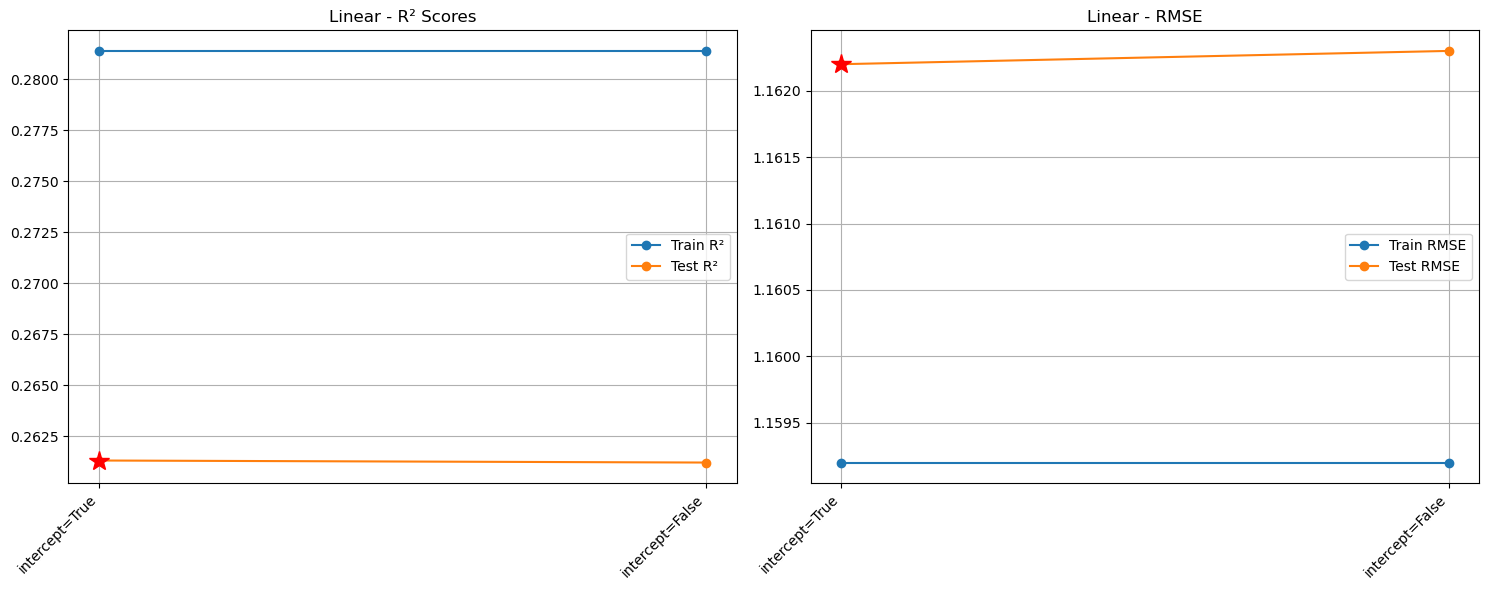

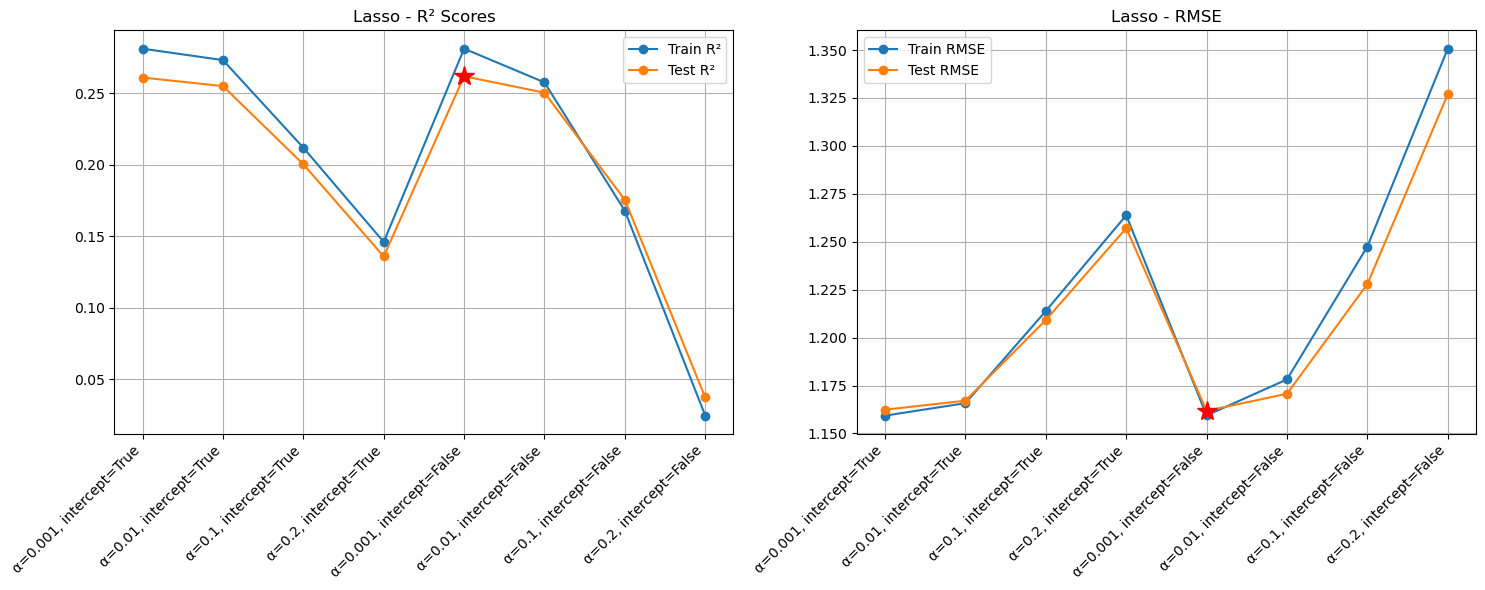

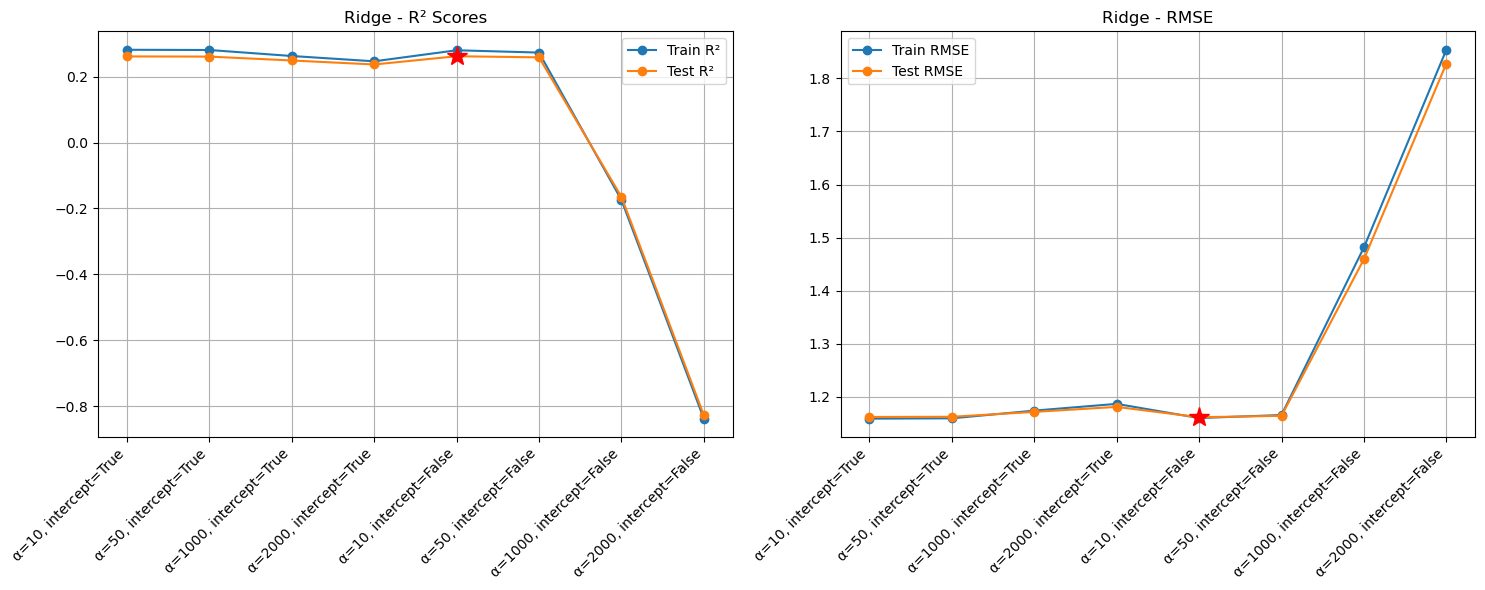

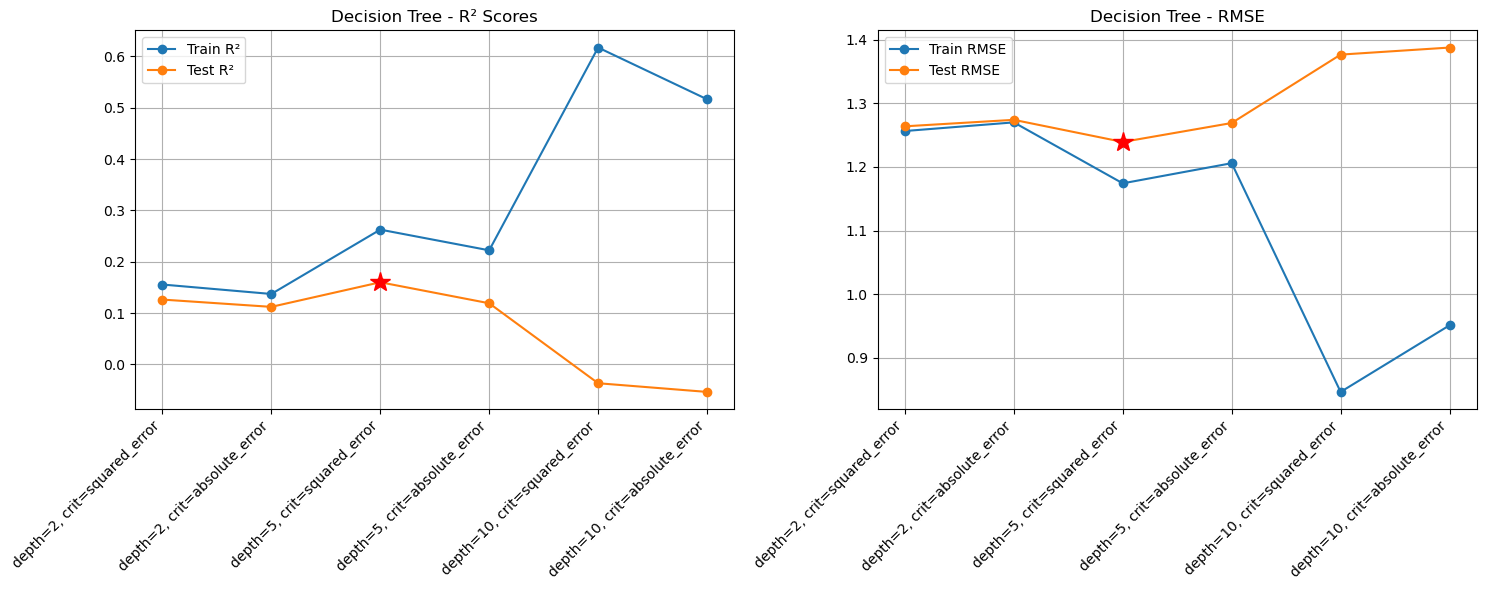

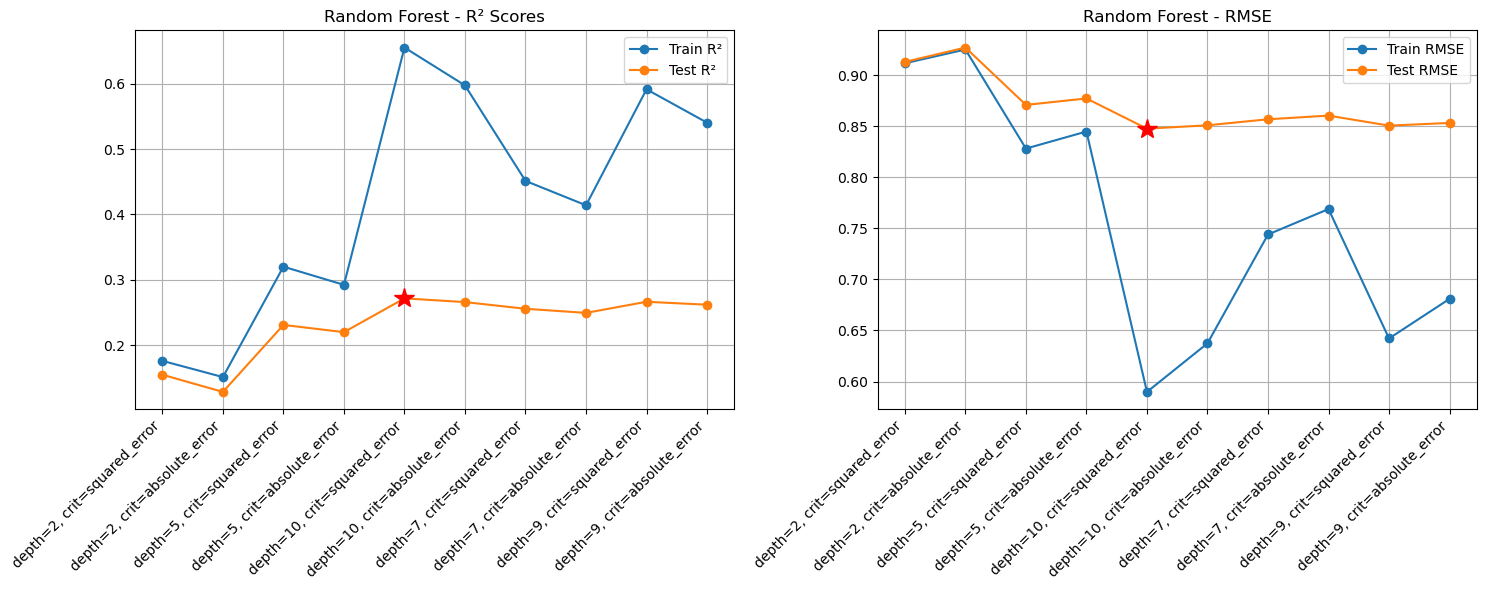

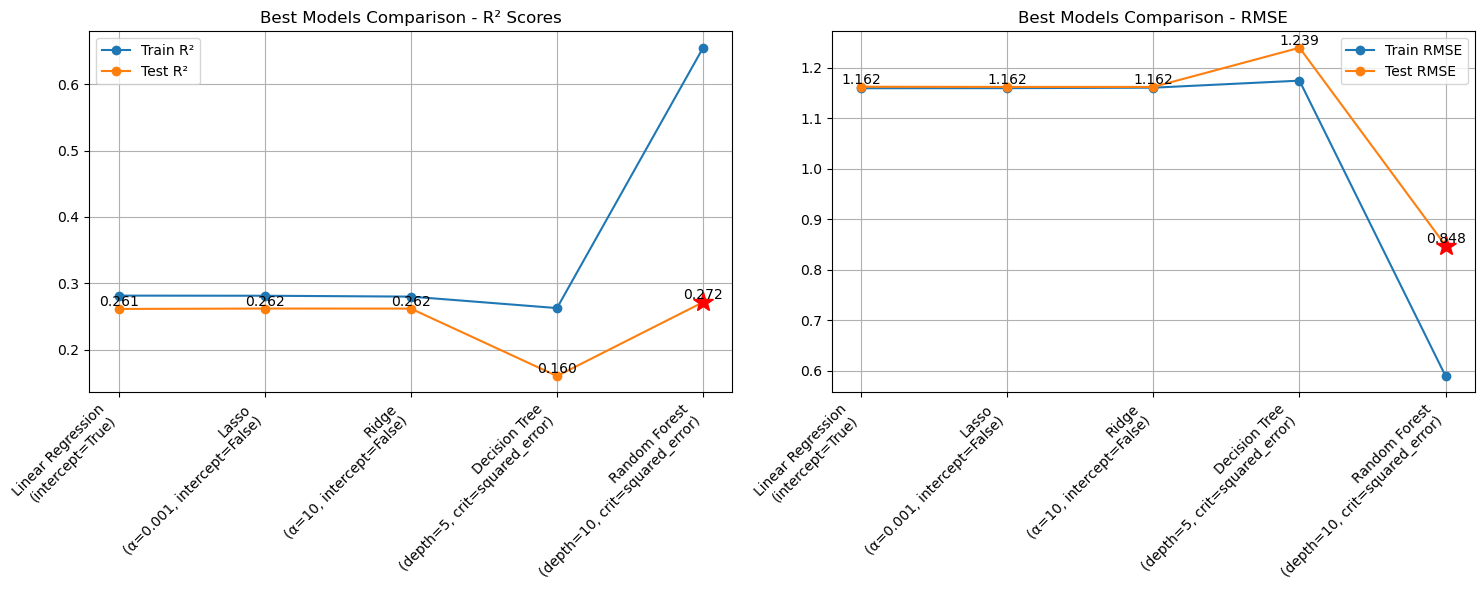

In [55]:
#%% evaluation

# Evaluation
# Sort and find best model
df_metrics = pd.DataFrame.from_dict(performance_metrics, orient='index')
# Round metrics to 4 decimal places before sorting
df_metrics = df_metrics.round(4)
# Sort by metrics with priority: test_rmse > test_r2 > train_rmse > train_r2
df_metrics_sorted = df_metrics.sort_values(
    ['test_rmse', 'test_r2', 'train_rmse', 'train_r2'], 
    ascending=[True, False, True, False]
)

# Get best model for each type
model_types = {
    'Linear': 'Linear',
    'Lasso': 'Lasso', 
    'Ridge': 'Ridge',
    'Decision Tree': 'Decision Tree',
    'Random Forest': 'Random Forest'
}

best_models = {}
for model_type in model_types.values():
    type_models = df_metrics_sorted[df_metrics_sorted.index.str.startswith(model_type)]
    if not type_models.empty:
        best_models[model_type] = type_models.index[0]

# Print sorted performance metrics
print("\nPerformance metrics for all models (sorted by test RMSE and test R²):")
print("=" * 80)
print(df_metrics_sorted.to_string())

# Visualization functions
def create_model_comparison_plot(df, model_type, ax1, ax2):
    model_data = df[df.index.str.startswith(model_type)]
    if model_data.empty:
        return
    
    # Create shortened labels
    labels = []
    for idx in model_data.index:
        # Extract parameters part
        params = idx.split('(')[1].rstrip(')')
        # Shorten parameter names
        params = params.replace('max_depth', 'md').replace('min_samples_leaf', 'msl') \
                      .replace('criterion', 'crit').replace('n_estimators', 'n_est') \
                      .replace('learning_rate', 'lr').replace('alpha', 'a')
        labels.append(params)
    
    x = range(len(model_data))
    
    # Plot R2
    ax1.plot(x, model_data['train_r2'], label='Train R²', marker='o')
    ax1.plot(x, model_data['test_r2'], label='Test R²', marker='o')
    
    # Add star for best model
    best_idx = model_data['test_rmse'].idxmin()
    best_x = list(model_data.index).index(best_idx)
    ax1.plot(best_x, model_data.loc[best_idx, 'test_r2'], marker='*', color='red', markersize=15)
    
    ax1.set_title(f'{model_type} - R² Scores')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True)
    
    # Plot RMSE
    ax2.plot(x, model_data['train_rmse'], label='Train RMSE', marker='o')
    ax2.plot(x, model_data['test_rmse'], label='Test RMSE', marker='o')
    
    # Add star for best model
    ax2.plot(best_x, model_data.loc[best_idx, 'test_rmse'], marker='*', color='red', markersize=15)
    
    ax2.set_title(f'{model_type} - RMSE')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True)

# Plot each model type separately
for model_type in model_types.values():
    if df_metrics[df_metrics.index.str.startswith(model_type)].empty:
        continue
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    create_model_comparison_plot(df_metrics, model_type, ax1, ax2)
    plt.tight_layout()
    plt.show()

# Plot comparison of best models
best_models_data = df_metrics.loc[list(best_models.values())]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create shortened labels for parameter names
best_labels = []
param_abbreviations = {
    'max_depth': 'md', 
    'min_samples_leaf': 'msl',
    'criterion': 'crit',
    'n_estimators': 'n_est',
    'learning_rate': 'lr',
    'alpha': 'a'
}

for model_name in best_models.values():
    if '(' in model_name:
        base_name = model_name.split('(')[0].strip()
        params = model_name.split('(')[1].rstrip(')')
        for full, abbr in param_abbreviations.items():
            params = params.replace(full, abbr)
        best_labels.append(f"{base_name}\n({params})")
    else:
        best_labels.append(model_name)

x = range(len(best_models))
# Plot best models R2
ax1.plot(x, best_models_data['train_r2'], label='Train R²', marker='o')
test_r2_line = ax1.plot(x, best_models_data['test_r2'], label='Test R²', marker='o')[0]
# Add value annotations for test R²
for i, v in enumerate(best_models_data['test_r2']):
    ax1.text(i, v, f'{v:.3f}', ha='center', va='bottom')
# Add star for best R2 model
best_r2_idx = best_models_data['test_r2'].idxmax()
best_r2_x = list(best_models.values()).index(best_r2_idx)
ax1.plot(best_r2_x, best_models_data.loc[best_r2_idx, 'test_r2'], marker='*', color='red', markersize=15)
ax1.set_title('Best Models Comparison - R² Scores')
ax1.set_xticks(x)
ax1.set_xticklabels(best_labels, rotation=45, ha='right')
ax1.legend()
ax1.grid(True)

# Plot best models RMSE
ax2.plot(x, best_models_data['train_rmse'], label='Train RMSE', marker='o')
test_rmse_line = ax2.plot(x, best_models_data['test_rmse'], label='Test RMSE', marker='o')[0]
# Add value annotations for test RMSE
for i, v in enumerate(best_models_data['test_rmse']):
    ax2.text(i, v, f'{v:.3f}', ha='center', va='bottom')
# Add star for best RMSE model
best_rmse_idx = best_models_data['test_rmse'].idxmin()
best_rmse_x = list(best_models.values()).index(best_rmse_idx)
ax2.plot(best_rmse_x, best_models_data.loc[best_rmse_idx, 'test_rmse'], marker='*', color='red', markersize=15)
ax2.set_title('Best Models Comparison - RMSE')
ax2.set_xticks(x)
ax2.set_xticklabels(best_labels, rotation=45, ha='right')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [26]:
#%% Conclusion

# 1 Performance
# Linear models (linear regression, lasso, ridge) are faster but less powerful in this dataset.
# Tree models (decision tree and random forest) are relatively slower but have better performance.    
# The model comparison indicates that there is probably a non-linear structure in the data, so tree models generally perform better than linear models.



# 2 Patterns during tuning
# Additionally, during the tuning process, some salient patterns of how parameters impact the performance emerge:
# 1. For basic linear models, whether intercept is included does not make a big difference.
# 2. For linear models with regularization (lasso and ridge), generally speaking, as the regularization parameter alpha increases, the performance decreases. When intercept is not included, the performance decreases more when alpha increases. 
# This overall pattern is likely because: 1) for alpha effect: perhaps the data is complex, so when the regularization effect is strong, the model will fail to fit the data well, resulting in poor performance for both training and testing sets. 2) for "without intercept, alpha effect is more pronounced": my guess is that the target variable swls is not centered. In this case, when intercept is not included, the model will fail to fit the data well, especially when the model is relatively naive (alpha is large).
# 3. For tree models (decision tree and random forest), the patterns are similar. The performance is generally better with a larger max depth, while the performance of different criterion is similar (squared error is slightly better than absolute error). Random forest is generally better than decision tree, especially when max depth is large.
# This pattern is likely because: 1) for max depth: probably the data is complex, so the more complex the model, the better the performance. 2) comparison between decision tree and random forest: random forest is generally better than decision tree, especially when max depth is large. This is likely because random forest uses multiple trees to make predictions, which is more robust to overfitting problem.


Best Model: Random Forest (depth=10, criterion=squared_error)

Best Model Performance:
train_r2      0.6552
test_r2       0.2715
train_rmse    0.5898
test_rmse     0.8478

Model Type: Random Forest
Parameters: depth=10, criterion=squared_error


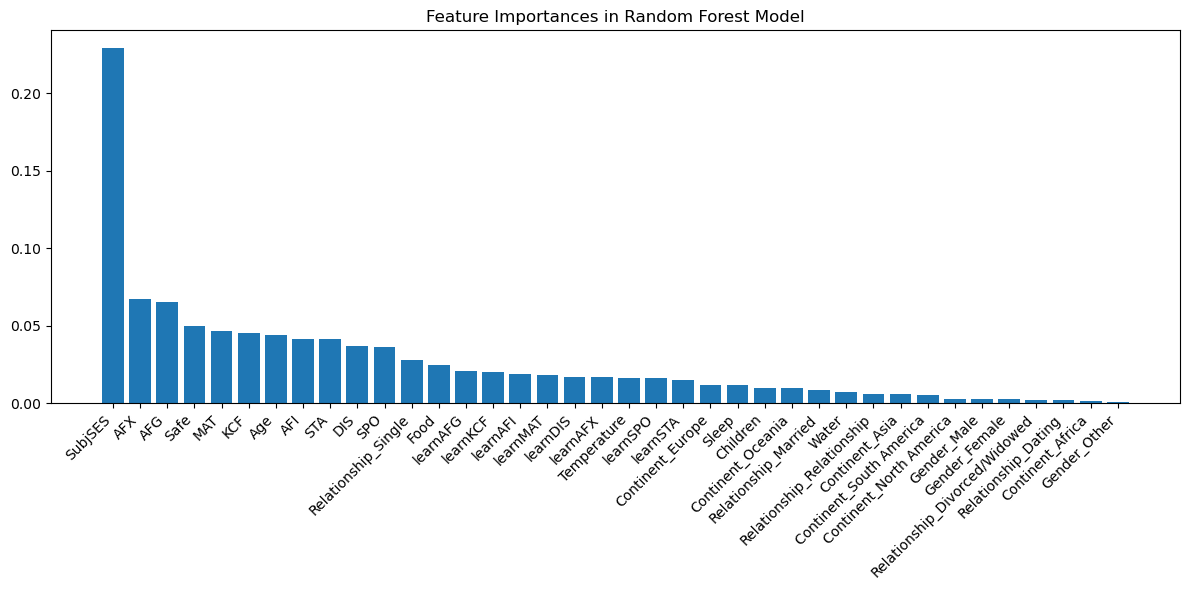


Top 5 Most Important Features:
    feature  importance
0   SubjSES    0.229088
12      AFX    0.067043
10      AFG    0.065389
7      Safe    0.049640
14      MAT    0.046594


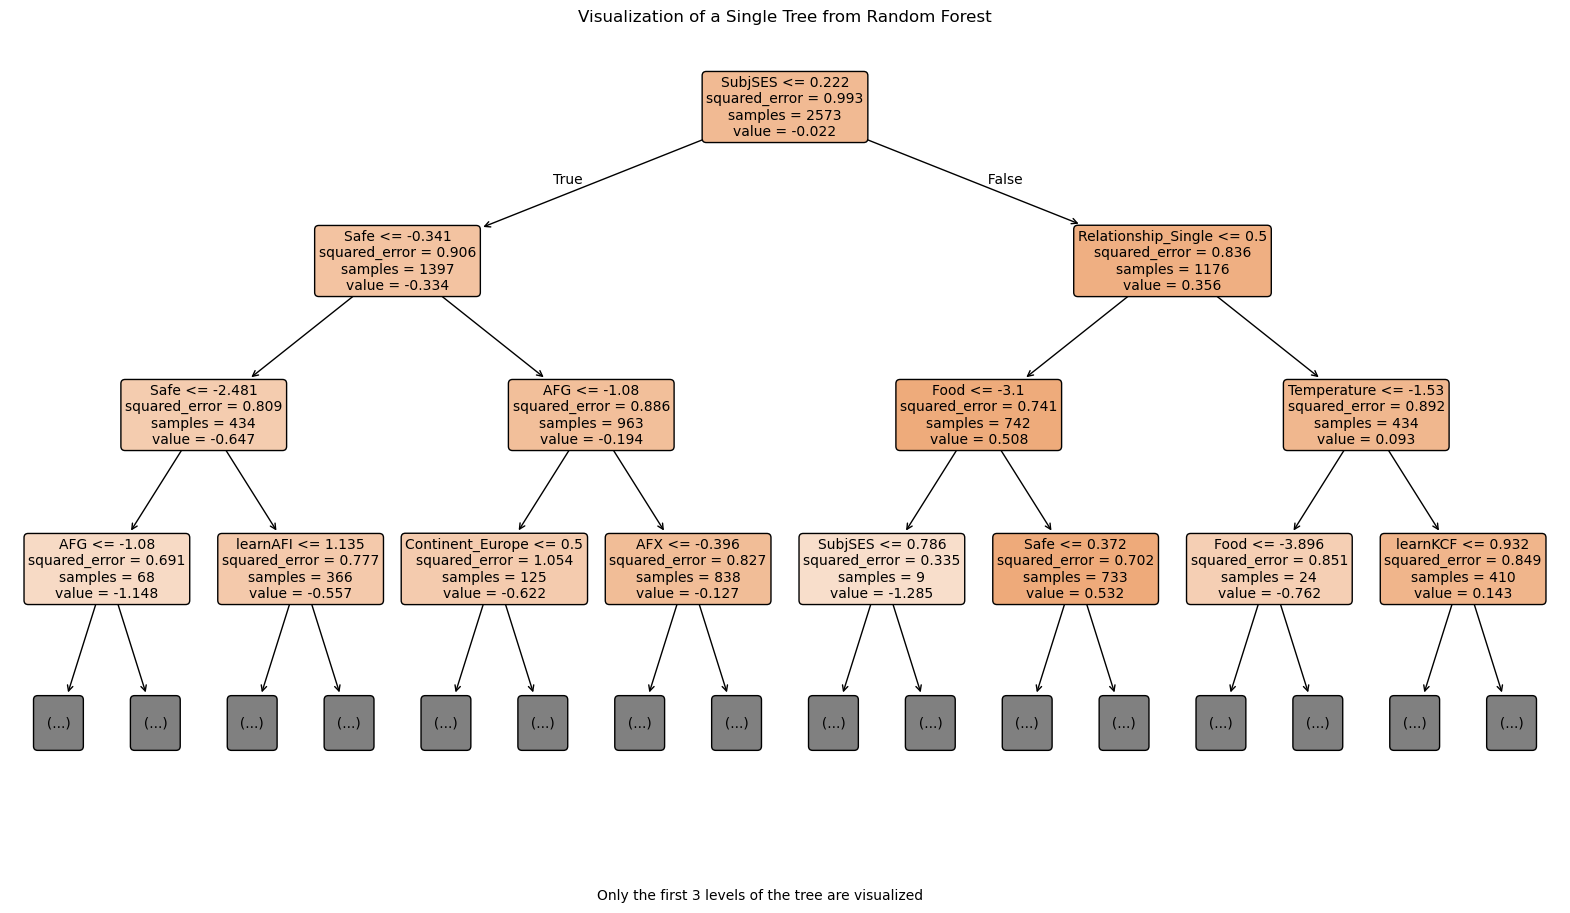

In [66]:
#%% Examine the winning model

# 1 Examine the winning model
# 1-1 Extract the best model information
best_model_name = df_metrics_sorted.index[0]
print("\nBest Model:", best_model_name)
print("\nBest Model Performance:")
print(df_metrics_sorted.iloc[0].to_string())

# Extract model type and parameters
model_type = best_model_name.split('(')[0].strip()
params = best_model_name.split('(')[1].rstrip(')')

print("\nModel Type:", model_type)
print("Parameters:", params)


# 1-2 Train the best Random Forest model
rf_model = RandomForestRegressor(max_depth=10, 
                               criterion='squared_error',
                               n_estimators=500,
                               random_state=133,
                               n_jobs=-1)
rf_model.fit(X_train, y_train)


# 1-3 Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance['importance'])
plt.xticks(range(len(feature_importance)), feature_importance['feature'], rotation=45, ha='right')
plt.title('Feature Importances in Random Forest Model')
plt.tight_layout()
plt.show()

# Print top 5 most important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head(5).to_string())


# 1-4 extract a single tree from the forest to visualize
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0], 
         feature_names=X_train.columns,
         filled=True,
         rounded=True,
         fontsize=10,
         max_depth=3)  # Limit tree depth visualization to 3 levels
plt.title("Visualization of a Single Tree from Random Forest")
plt.figtext(0.5, 0.01, "Only the first 3 levels of the tree are visualized", ha='center')
plt.show()

# interpretation:
#---------------------------------

In [37]:
from sklearn.metrics import mean_absolute_error
# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Now y_pred exists and can be used
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

MAE: 0.6740679196783592


In [49]:
from sklearn.metrics import mean_absolute_error
# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Now y_pred exists and can be used
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

print(y_test.shape)  # Ground truth shape
print(y_pred.shape)  # Predicted values shape

# Compute absolute error per row
errors = np.abs(y_test - y_pred)

# Convert to DataFrame
error_df = pd.DataFrame({'Error': errors})

# Sort in descending order
error_df_sorted = error_df.sort_values(by='Error', ascending=False)

# Display sorted errors
print(error_df_sorted)

MAE: 0.6740679196783592
(2766,)
(2766,)
         Error
4640  2.990009
795   2.951907
4641  2.896944
3053  2.831458
6682  2.712945
...        ...
4096  0.000975
4049  0.000803
2587  0.000729
3788  0.000445
2636  0.000192

[2766 rows x 1 columns]


In [58]:
# Assuming 'original_df' is your original dataset and 'index_error' contains the index and error data
index_error = pd.DataFrame({
    'Error': [2.990009, 2.951907, 2.896944, 2.831458, 2.712945]
}, index=[4640, 795, 4641, 3053, 6682])

# Merge the original dataset with the error data using the index
merged_df = df.loc[index_error.index].copy()

# Add the 'Error' column to the merged dataset
merged_df['Error'] = index_error['Error'].values
pd.set_option('display.max_columns', None)
# Now 'merged_df' contains the specific rows with their corresponding 'Error' values
print(merged_df)

      swls  SubjSES   Age  Children  Food  Water  Sleep  Temperature  Safe  \
4640   7.0     10.0  51.0       2.0   7.0    7.0    7.0          7.0   7.0   
795    1.0      8.0  38.0       1.0   5.0    6.0    6.0          6.0   5.0   
4641   7.0     10.0  51.0       2.0   7.0    7.0    7.0          7.0   7.0   
3053   1.4      7.0  21.0       0.0   7.0    7.0    7.0          7.0   7.0   
6682   7.0      1.0  40.0       3.0   7.0    7.0    7.0          7.0   7.0   

           SPO       DIS       AFG       AFI       AFX       STA       MAT  \
4640  4.833333  6.000000  3.666667  4.500000  3.500000  5.500000  2.000000   
795   5.333333  6.000000  4.833333  6.666667  5.166667  5.333333  4.166667   
4641  4.000000  4.000000  4.000000  4.000000  4.000000  4.000000  4.000000   
3053  5.000000  3.333333  6.333333  3.666667  4.333333  5.000000  2.166667   
6682  5.500000  6.000000  3.333333  6.500000  3.166667  4.333333  1.000000   

           KCF  learnSPO  learnDIS  learnAFG  learnAFI  learnA

In [48]:
#define and fit the model
lasso_model = Lasso(alpha=0.001, fit_intercept=False)
lasso_model.fit(X_train, y_train)

# Make predictions
y_pred = lasso_model.predict(X_test)

# Now y_pred exists and can be used
mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

print(y_test.shape)  # Ground truth shape
print(y_pred.shape)  # Predicted values shape

# Compute absolute error per row
errors = np.abs(y_test - y_pred)

# Convert to DataFrame
error_df = pd.DataFrame({'Error': errors})

# Sort in descending order
error_df_sorted = error_df.sort_values(by='Error', ascending=False)

# Display sorted errors
print(error_df_sorted)

MAE: 0.683025123007108
(2766,)
(2766,)
         Error
3053  3.000884
1257  2.832515
4630  2.772064
5104  2.710953
6682  2.690689
...        ...
1419  0.003303
3665  0.002794
4046  0.002618
912   0.001566
6273  0.000761

[2766 rows x 1 columns]


In [59]:
index_error = pd.DataFrame({
    'Error': [3.000884, 2.832515, 2.772064, 2.710953, 2.690689]
}, index=[3053, 1257, 4630, 5104, 6682])

# Merge the original dataset with the error data using the index
merged_df = df.loc[index_error.index].copy()

# Add the 'Error' column to the merged dataset
merged_df['Error'] = index_error['Error'].values
pd.set_option('display.max_columns', None)
# Now 'merged_df' contains the specific rows with their corresponding 'Error' values
print(merged_df)

      swls  SubjSES   Age  Children  Food  Water  Sleep  Temperature  Safe  \
3053   1.4      7.0  21.0       0.0   7.0    7.0    7.0          7.0   7.0   
1257   1.0      6.0  29.0       0.0   7.0    7.0    7.0          7.0   7.0   
4630   2.0     10.0  51.0       2.0   7.0    7.0    7.0          7.0   7.0   
5104   1.0      5.0  24.0       0.0   7.0    7.0    7.0          7.0   7.0   
6682   7.0      1.0  40.0       3.0   7.0    7.0    7.0          7.0   7.0   

           SPO       DIS       AFG       AFI       AFX       STA       MAT  \
3053  5.000000  3.333333  6.333333  3.666667  4.333333  5.000000  2.166667   
1257  2.833333  3.333333  3.000000  4.500000  1.000000  2.333333  4.000000   
4630  4.600000  3.400000  6.600000  4.400000  2.200000  5.400000  1.000000   
5104  5.500000  5.400000  6.500000  1.833333  2.000000  7.000000  5.500000   
6682  5.500000  6.000000  3.333333  6.500000  3.166667  4.333333  1.000000   

           KCF  learnSPO  learnDIS  learnAFG  learnAFI  learnA

Features shape: (6914, 38)

First few rows of features:
    SubjSES       Age  Children    Food     Water     Sleep  Temperature  \
0 -0.623029 -0.860878 -0.436772  0.4821  0.401934  0.429817     0.525169   
1 -1.186633 -0.860878 -0.436772  0.4821  0.401934  0.429817     0.525169   
2 -1.750237 -0.051929 -0.436772  0.4821  0.401934  0.429817     0.525169   
3 -1.750237 -0.051929 -0.436772  0.4821  0.401934  0.429817     0.525169   
4  0.504179 -0.770995 -0.436772  0.4821  0.401934  0.429817    -1.118942   

       Safe       SPO       DIS  ...  Relationship_Divorced/Widowed  \
0  0.728488  0.307635 -0.357839  ...                            0.0   
1  0.728488  0.307635  1.116106  ...                            0.0   
2  0.728488  0.334968  0.472930  ...                            0.0   
3  0.728488  0.717626 -0.625829  ...                            0.0   
4  0.015368 -0.239019  0.044146  ...                            0.0   

   Relationship_Married  Relationship_Relationship  Relation

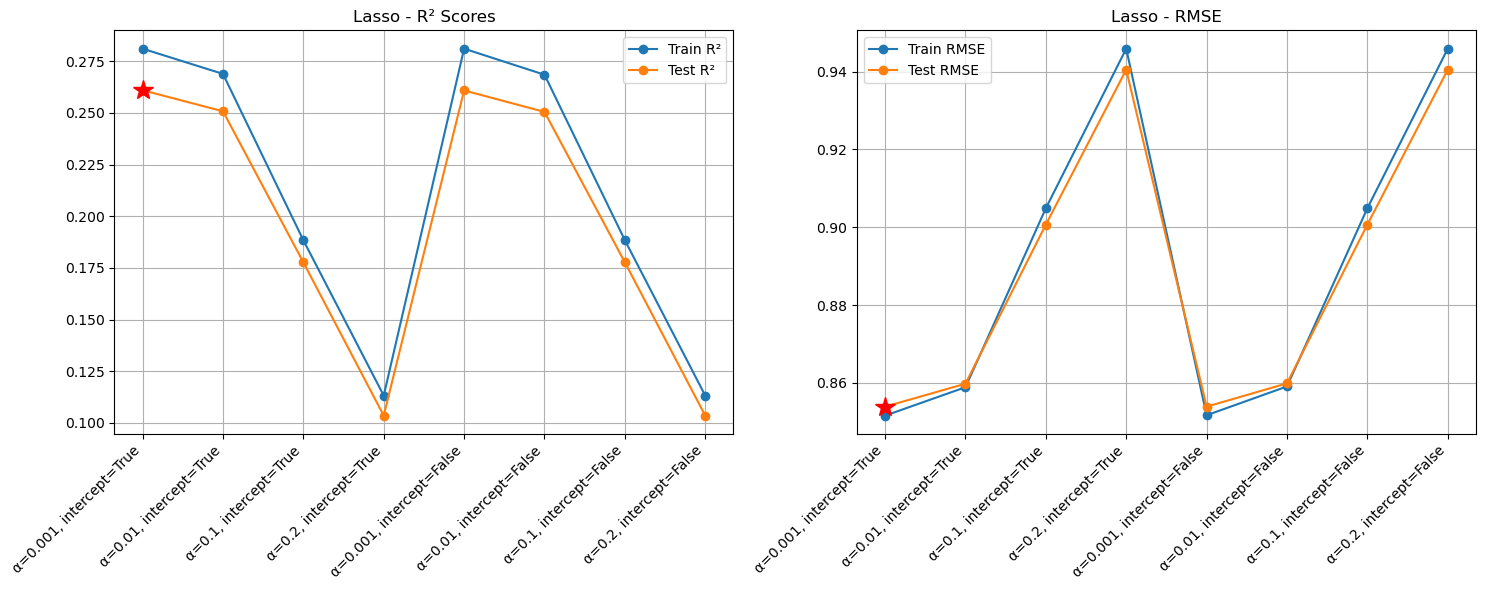

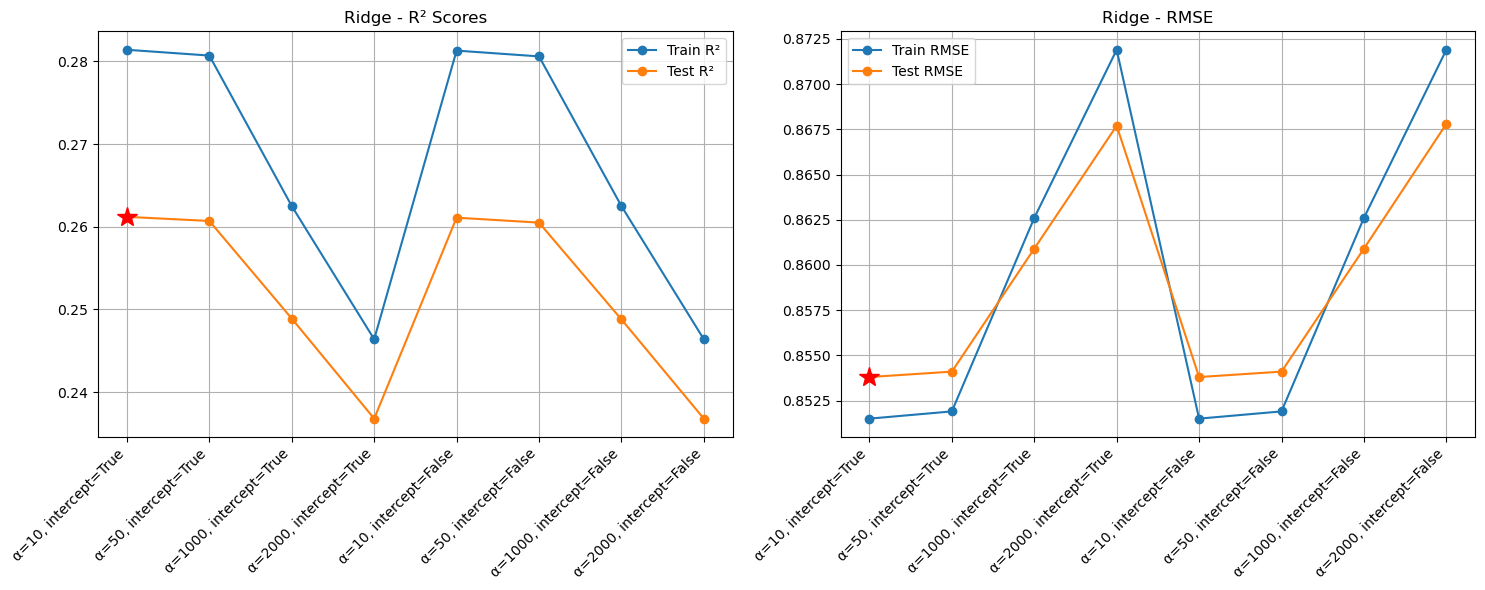

In [31]:
# %% Validation

# 2 Validation to 3-2-2
# Phenomenon: When intercept is not included, the performance decreases more when alpha increases
# Hypothesis: The target variable is not centered 
# Validation: Standardization on target variable

# Preprocessing features
X_num = df[numerical_vars]
X_cat = df[categorical_vars]

# Scale numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(scaler.fit_transform(X_num), columns=X_num.columns)
# Standardize target variable as well
y_scaled = pd.Series(scaler.fit_transform(y.values.reshape(-1, 1)).ravel(), index=y.index)
# Encode categorical features
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded = pd.DataFrame(X_cat_encoded, columns=encoder.get_feature_names_out())


X = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
y = y_scaled

print("Features shape:", X.shape)
print("\nFirst few rows of features:")
print(X.head())
print("\nFirst few rows of target:")
print(y.head())

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=133)

# Create a new performance metrics dictionary for standardized target models
performance_metrics_val = {}


# Lasso (L1 Regularization) with different parameters
from sklearn.linear_model import Lasso


lasso_alphas = [0.001, 0.01, 0.1, 0.2]
# With intercept, different alphas
for alpha in lasso_alphas:
    lasso_model = Lasso(alpha=alpha, fit_intercept=True)
    lasso_results = train_evaluate(lasso_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=True")
    model_name = f'Lasso (α={alpha}, intercept=True)'
    performance_metrics_val[model_name] = lasso_results['performance']

# Without intercept, different alphas
for alpha in lasso_alphas:
    lasso_model = Lasso(alpha=alpha, fit_intercept=False)
    lasso_results = train_evaluate(lasso_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=False")
    model_name = f'Lasso (α={alpha}, intercept=False)'
    performance_metrics_val[model_name] = lasso_results['performance']
 
# Ridge (L2 Regularization) with different parameters
from sklearn.linear_model import Ridge

ridge_alphas = [10,50, 1000, 2000]
# With intercept, different alphas
for alpha in ridge_alphas:
    ridge_model = Ridge(alpha=alpha, fit_intercept=True)
    ridge_results = train_evaluate(ridge_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=True")
    model_name = f'Ridge (α={alpha}, intercept=True)'
    performance_metrics_val[model_name] = ridge_results['performance']

# Without intercept, different alphas
for alpha in ridge_alphas:
    ridge_model = Ridge(alpha=alpha, fit_intercept=False)
    ridge_results = train_evaluate(ridge_model, X_train, X_test, y_train, y_test, params=f"alpha={alpha}, fit_intercept=False")
    model_name = f'Ridge (α={alpha}, intercept=False)'
    performance_metrics_val[model_name] = ridge_results['performance']


# Evaluation
# Sort and find best model
df_metrics_val = pd.DataFrame.from_dict(performance_metrics_val, orient='index')
# Round metrics to 4 decimal places before sorting
df_metrics_val = df_metrics_val.round(4)
# Sort by metrics with priority: test_rmse > test_r2 > train_rmse > train_r2
df_metrics_sorted_val = df_metrics_val.sort_values(
    ['test_rmse', 'test_r2', 'train_rmse', 'train_r2'], 
    ascending=[True, False, True, False]
)

# Get best model for each type
model_types = {
    'Lasso': 'Lasso', 
    'Ridge': 'Ridge'
}

best_models = {}
for model_type in model_types.values():
    type_models = df_metrics_sorted[df_metrics_sorted.index.str.startswith(model_type)]
    if not type_models.empty:
        best_models[model_type] = type_models.index[0]

# Print sorted performance metrics
print("\nPerformance metrics for all models (sorted by test RMSE and test R²):")
print("=" * 80)
print(df_metrics_sorted_val.to_string())
# Visualization functions
def create_model_comparison_plot(df, model_type, ax1, ax2):
    model_data = df[df.index.str.startswith(model_type)]
    if model_data.empty:
        return
    
    # Create shortened labels
    labels = []
    for idx in model_data.index:
        # Extract parameters part
        params = idx.split('(')[1].rstrip(')')
        # Shorten parameter names
        params = params.replace('max_depth', 'md').replace('min_samples_leaf', 'msl') \
                      .replace('criterion', 'crit').replace('n_estimators', 'n_est') \
                      .replace('learning_rate', 'lr').replace('alpha', 'a')
        labels.append(params)
    
    x = range(len(model_data))
    
    # Plot R2
    ax1.plot(x, model_data['train_r2'], label='Train R²', marker='o')
    ax1.plot(x, model_data['test_r2'], label='Test R²', marker='o')
    
    # Add star for best model
    best_idx = model_data['test_rmse'].idxmin()
    best_x = list(model_data.index).index(best_idx)
    ax1.plot(best_x, model_data.loc[best_idx, 'test_r2'], marker='*', color='red', markersize=15)
    
    ax1.set_title(f'{model_type} - R² Scores')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True)
    
    # Plot RMSE
    ax2.plot(x, model_data['train_rmse'], label='Train RMSE', marker='o')
    ax2.plot(x, model_data['test_rmse'], label='Test RMSE', marker='o')
    
    # Add star for best model
    ax2.plot(best_x, model_data.loc[best_idx, 'test_rmse'], marker='*', color='red', markersize=15)
    
    ax2.set_title(f'{model_type} - RMSE')
    ax2.set_xticks(x)
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.legend()
    ax2.grid(True)

# Plot each model type separately
for model_type in model_types.values():
    if df_metrics[df_metrics.index.str.startswith(model_type)].empty:
        continue
        
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    create_model_comparison_plot(df_metrics_val, model_type, ax1, ax2)
    plt.tight_layout()
    plt.show()

# Conclusion: With standardization on the target variable, there is no significant difference in performance between models with and without intercept (given the same alpha). Thus our previous explanation is supported.